In [1]:
from datasets import load_dataset

dataset_name = "dim/nfs_pix2pix_1920_1080_v5"
# dataset_name = "dim/nfs_pix2pix_1920_1080_v5_upscale_2x_raw"
# dataset_name = "dim/nfs_pix2pix_1920_1080_v6"
# dataset_name = "dim/render_nfs_4screens_6_sdxl_1_wan_mix"
# dataset_name = "dim/render_nfs_4screens_5_sdxl_1_wan_mix"
dataset = load_dataset(
    dataset_name,
    cache_dir=f"dataset/{dataset_name.split('/')[-1]}",
)
# dataset["train"] = dataset["train"].shuffle(seed=2025)
dataset = dataset["train"]

c:\programming\auto_remaster\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset[0]

{'input_image': <PIL.PngImagePlugin.PngImageFile image mode=P size=1920x1080>,
 'edit_prompt': 'make nfs 2005 photorealistic',
 'edited_image': <PIL.PngImagePlugin.PngImageFile image mode=P size=1920x1080>}

In [2]:
import torch

torch.tensor(1).cuda()

tensor(1, device='cuda:0')

In [14]:
from PIL import Image
import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    StableDiffusionPipeline,
    UNet2DConditionModel,
    StableDiffusionImg2ImgPipeline,
    AutoencoderTiny,
    UNet2DModel,
    FlowMatchEulerDiscreteScheduler,
)
import numpy as np
import torch
from torchvision import transforms
from auto_remaster.sandbox.flux2_tiny_autoencoder import Flux2TinyAutoEncoder

noise_scheduler = FlowMatchEulerDiscreteScheduler()

# 1. Загрузка VAE (Tiny Autoencoder для скорости и экономии памяти)
# vae_val = AutoencoderTiny.from_pretrained(
#     "madebyollin/taesd",
#     torch_device="cuda",
#     torch_dtype=weight_dtype,
# ).to(accelerator.device)
# vae_val.decoder.ignore_skip = False
weight_dtype = torch.bfloat16
# weight_dtype = torch.float32
device = "cuda"
resolution = 512
checkpoint_path = (
    "inference_optimization/models/lbm_train_test_gap_struct_noise/checkpoint-177600"
)
vae_val = AutoencoderKL.from_pretrained(
    # "black-forest-labs/FLUX.1-dev",
    "black-forest-labs/FLUX.2-dev",
    # checkpoint_path,
    subfolder="vae",
    torch_device="cuda",
    torch_dtype=weight_dtype,
).to(device)
# vae_val = Flux2TinyAutoEncoder.from_pretrained(
#     "fal/FLUX.2-Tiny-AutoEncoder",
#     torch_dtype=weight_dtype,
# ).to(device)
vae_val.requires_grad_(False)
vae_val.eval()
# checkpoint_path = "checkpoints/auto_remaster/lbm/checkpoint-28800"
# 2. Загрузка UNet из чекпоинта
unet_val = UNet2DModel.from_pretrained(
    checkpoint_path,
    subfolder="unet",
    torch_dtype=weight_dtype,
).to(device)
unet_val.requires_grad_(False)

# 3. Подготовка трансформаций
valid_transforms = transforms.Compose(
    [
        transforms.Resize(
            resolution,
            interpolation=transforms.InterpolationMode.LANCZOS,
        ),
        transforms.CenterCrop(resolution),
    ]
)
train_transforms = transforms.Compose(
    [
        transforms.Resize(
            resolution,
            interpolation=transforms.InterpolationMode.LANCZOS,
        ),
        transforms.CenterCrop(resolution),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.5, 0.5, 0.5),
            (0.5, 0.5, 0.5),
        ),
    ]
)


# Вспомогательная функция для получения сигм (как в основном скрипте)
def _get_sigmas_val(
    scheduler,
    timesteps,
    n_dim=4,
    dtype=torch.float32,
    device="cpu",
):
    sigmas = scheduler.sigmas.to(device=device, dtype=dtype)
    schedule_timesteps = scheduler.timesteps.to(device)
    timesteps = timesteps.to(device)
    step_indices = [(schedule_timesteps == t).nonzero().item() for t in timesteps]
    sigma = sigmas[step_indices].flatten()
    while len(sigma.shape) < n_dim:
        sigma = sigma.unsqueeze(-1)
    return sigma

c:\programming\auto_remaster\venv\Lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
Some weights of the model checkpoint at black-forest-labs/FLUX.2-dev were not used when initializing AutoencoderKL: 
 ['bn.num_batches_tracked, bn.running_var, bn.running_mean']


In [ ]:
noise_scheduler.timesteps

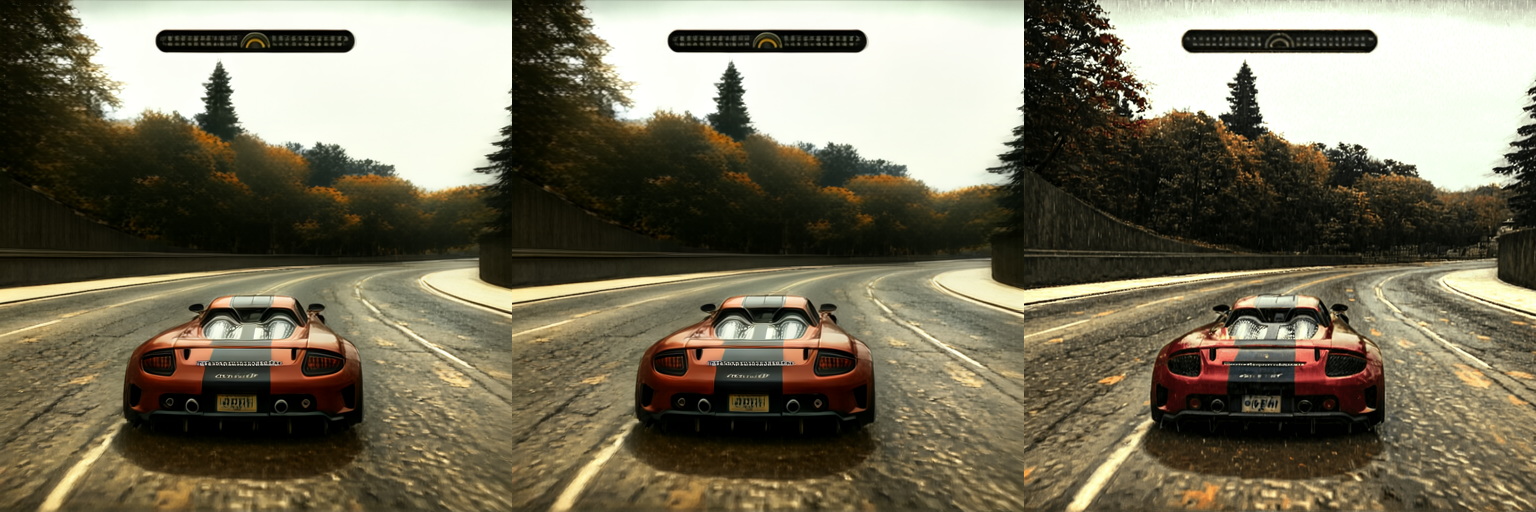

In [16]:
# ---------------------------------------------------------
# НАСТРОЙКА ШЕДУЛЕРА
# ---------------------------------------------------------
from accelerate.utils import ProjectConfiguration, set_seed


def create_frequency_soft_cutoff_mask(
    height: int,
    width: int,
    cutoff_radius: float,
    transition_width: float = 5.0,
    device: torch.device = None,
) -> torch.Tensor:
    """
    Create a smooth frequency cutoff mask for low-pass filtering.

    Args:
        height: Image height
        width: Image width
        cutoff_radius: Frequency cutoff radius (0 = no structure, max_radius = full structure)
        transition_width: Width of smooth transition (smaller = sharper cutoff)
        device: Device to create tensor on

    Returns:
        torch.Tensor: Frequency mask of shape (height, width)
    """
    if device is None:
        device = torch.device("cpu")

    # Create frequency coordinates
    u = torch.arange(height, device=device)
    v = torch.arange(width, device=device)
    u, v = torch.meshgrid(u, v, indexing="ij")

    # Calculate distance from center
    center_u, center_v = height // 2, width // 2
    frequency_radius = torch.sqrt((u - center_u) ** 2 + (v - center_v) ** 2)

    # Create smooth transition mask
    mask = torch.exp(
        -((frequency_radius - cutoff_radius) ** 2) / (2 * transition_width**2)
    )
    mask = torch.where(frequency_radius <= cutoff_radius, torch.ones_like(mask), mask)

    return mask


def clip_frequency_magnitude(noise_magnitudes, clip_percentile=0.95):
    """Clip frequency domain magnitude to prevent large values."""

    # Calculate clipping threshold
    clip_threshold = torch.quantile(noise_magnitudes, clip_percentile)

    # Clip large values
    clipped_magnitudes = torch.clamp(noise_magnitudes, max=clip_threshold)

    return clipped_magnitudes


def generate_structured_noise_batch_vectorized(
    image_batch: torch.Tensor,
    noise_std: float = 1.0,
    pad_factor: float = 1.5,
    cutoff_radius: float = None,
    transition_width: float = 2.0,
    input_noise: torch.Tensor = None,
    sampling_method: str = "fft",
) -> torch.Tensor:
    """
    Generate structured noise for a batch of images using frequency soft cutoff.
    Reduces boundary artifacts by padding images before FFT processing.

    Args:
        image_batch: Batch of image tensors of shape (B, C, H, W)
        noise_std: Standard deviation for Gaussian noise
        pad_factor: Padding factor (1.5 = 50% padding, 2.0 = 100% padding)
        cutoff_radius: Frequency cutoff radius (None = auto-calculate)
        transition_width: Width of smooth transition for frequency cutoff
        input_noise: Optional input noise tensor to use instead of generating new noise.
        sampling_method: Method to sample noise magnitude ('fft', 'cdf', 'two-gaussian')

    Returns:
        torch.Tensor: Batch of structured noise tensors of shape (B, C, H, W)
    """
    assert sampling_method in ["fft", "cdf", "two-gaussian"]
    # Ensure tensor is on the correct device
    batch_size, channels, height, width = image_batch.shape
    dtype = image_batch.dtype
    device = image_batch.device
    image_batch = image_batch.float()

    # Calculate padding size for overlap-add method
    pad_h = int(height * (pad_factor - 1))
    pad_h = pad_h // 2 * 2  # make it even
    pad_w = int(width * (pad_factor - 1))
    pad_w = pad_w // 2 * 2  # make it even

    # Pad images with reflection to reduce boundary artifacts
    padded_images = torch.nn.functional.pad(
        image_batch,
        (pad_w // 2, pad_w // 2, pad_h // 2, pad_h // 2),
        mode="reflect",  # Mirror edges for natural transitions
    )

    # Calculate padded dimensions
    padded_height = height + pad_h
    padded_width = width + pad_w

    # Create frequency soft cutoff mask only if cutoff_radius is provided
    if cutoff_radius is not None:
        cutoff_radius = min(min(padded_height / 2, padded_width / 2), cutoff_radius)
        freq_mask = create_frequency_soft_cutoff_mask(
            padded_height, padded_width, cutoff_radius, transition_width, device
        )
    else:
        # No cutoff - preserve all frequencies (full structure preservation)
        freq_mask = torch.ones(padded_height, padded_width, device=device)

    # Apply 2D FFT to padded images
    fft = torch.fft.fft2(padded_images, dim=(-2, -1))

    # Shift zero frequency to center
    fft_shifted = torch.fft.fftshift(fft, dim=(-2, -1))

    # Extract phase and magnitude for all images
    image_phases = torch.angle(fft_shifted)
    image_phases = clip_frequency_magnitude(image_phases)
    image_magnitudes = torch.abs(fft_shifted)

    if input_noise is not None:
        # Use provided noise
        noise_batch = torch.nn.functional.pad(
            input_noise,
            (pad_w // 2, pad_w // 2, pad_h // 2, pad_h // 2),
            mode="reflect",  # Mirror edges for natural transitions
        )
        noise_batch = noise_batch.float()
    else:
        # Generate Gaussian noise for the padded size
        noise_batch = torch.randn_like(padded_images)

    # Extract noise magnitude and phase
    if sampling_method == "fft":
        # Apply 2D FFT to noise batch
        noise_fft = torch.fft.fft2(noise_batch, dim=(-2, -1))
        noise_fft_shifted = torch.fft.fftshift(noise_fft, dim=(-2, -1))

        noise_magnitudes = torch.abs(noise_fft_shifted)
        noise_phases = torch.angle(noise_fft_shifted)
    elif sampling_method == "cdf":
        # The magnitude of FFT of Gaussian noise follows a Rayleigh distribution.
        # We can sample it directly.
        # The scale of the Rayleigh distribution is related to the std of the Gaussian noise
        # and the size of the FFT.
        # For an N-point FFT of Gaussian noise with variance sigma^2, the variance of
        # the real and imaginary parts of the FFT coefficients is N*sigma^2.
        # The scale parameter for the Rayleigh distribution is sqrt(N*sigma^2 / 2).
        # Here, N = padded_height * padded_width.

        N = padded_height * padded_width
        rayleigh_scale = (N / 2) ** 0.5

        ## Sample from a standard Rayleigh distribution (scale=1) and then scale it.
        uu = torch.rand(size=image_magnitudes.shape, device=device)
        noise_magnitudes = rayleigh_scale * torch.sqrt(-2.0 * torch.log(uu))
        if input_noise is not None:
            noise_fft = torch.fft.fft2(noise_batch, dim=(-2, -1))
            noise_fft_shifted = torch.fft.fftshift(noise_fft, dim=(-2, -1))

            noise_magnitudes = torch.abs(noise_fft_shifted)
            noise_phases = torch.angle(noise_fft_shifted)
        else:
            noise_phases = (
                torch.rand(size=image_magnitudes.shape, device=device) * 2 * torch.pi
                - torch.pi
            )
    elif sampling_method == "two-gaussian":
        N = padded_height * padded_width
        rayleigh_scale = (N / 2) ** 0.5
        # A standard Rayleigh can be generated from two standard normal distributions.
        u1 = torch.randn_like(image_magnitudes)
        u2 = torch.randn_like(image_magnitudes)
        noise_magnitudes = rayleigh_scale * torch.sqrt(u1**2 + u2**2)
        if input_noise is not None:
            noise_fft = torch.fft.fft2(noise_batch, dim=(-2, -1))
            noise_fft_shifted = torch.fft.fftshift(noise_fft, dim=(-2, -1))

            noise_magnitudes = torch.abs(noise_fft_shifted)
            noise_phases = torch.angle(noise_fft_shifted)
        else:
            noise_phases = (
                torch.rand(size=image_magnitudes.shape, device=device) * 2 * torch.pi
                - torch.pi
            )
    else:
        raise ValueError(f"Unknown sampling method: {sampling_method}")

    noise_magnitudes = clip_frequency_magnitude(noise_magnitudes)

    # Scale noise magnitude by standard deviation
    noise_magnitudes = noise_magnitudes * noise_std

    # Apply frequency soft cutoff to mix phases
    # Low frequencies (within cutoff) use image phase, high frequencies use noise phase
    mixed_phases = (
        freq_mask.unsqueeze(0).unsqueeze(0) * image_phases
        + (1 - freq_mask.unsqueeze(0).unsqueeze(0)) * noise_phases
    )

    # Combine magnitude and mixed phase for all images
    fft_combined = noise_magnitudes * torch.exp(1j * mixed_phases)
    # Shift zero frequency back to corner
    fft_unshifted = torch.fft.ifftshift(fft_combined, dim=(-2, -1))
    # Apply inverse FFT
    structured_noise_padded = torch.fft.ifft2(fft_unshifted, dim=(-2, -1))
    # Take real part
    structured_noise_padded = torch.real(structured_noise_padded)

    clamp_mask = (structured_noise_padded < -5) + (structured_noise_padded > 5)
    clamp_mask = (clamp_mask > 0).float()

    structured_noise_padded = (
        structured_noise_padded * (1 - clamp_mask) + noise_batch * clamp_mask
    )

    # Crop back to original size (remove padding)
    structured_noise_batch = structured_noise_padded[
        :, :, pad_h // 2 : pad_h // 2 + height, pad_w // 2 : pad_w // 2 + width
    ]
    return structured_noise_batch.to(dtype)


# num_steps = 1
num_steps = 8
# num_steps = 40
# num_steps = 1
# bridge_noise_sigma = 0.001
# bridge_noise_sigma = 0.01
bridge_noise_sigma = 0.0
sigmas = np.linspace(1.0, 1 / num_steps, num_steps)

noise_scheduler.set_timesteps(sigmas=sigmas, device=device)

# pos = 20000
# pos = 10000
# pos = 10100
# pos = 10200
# pos = 1727
# pos = 727
# pos = 527
# pos = 327
pos = 256
# pos = 227
# pos = 170
# pos = 0
import random

# test_images_ids = list(range(0, len(dataset), 30))
# rng = random.Random(2025)
# amount = min(30, len(test_images_ids))
# selected_ids = rng.sample(test_images_ids, amount)

# pos = 84
# pos = selected_ids[0]
# pos = selected_ids[24]
# pos = selected_ids[28]
# pos = selected_ids[7]
# pos = 0
item = dataset[pos]
source_image_name = "input_image"
target_image_name = "edited_image"
# Подготовка исходных изображений для визуализации и метрик
orig_source_pil = item[source_image_name].convert("RGB")
target_pil = item[target_image_name].convert("RGB")

noise_scheduler = FlowMatchEulerDiscreteScheduler()


# ---------------------------------------------------------
# НАСТРОЙКА ШЕДУЛЕРА
# ---------------------------------------------------------
# num_steps = diffusion_args.num_inference_steps

sigmas = np.linspace(1.0, 1 / num_steps, num_steps)

noise_scheduler.set_timesteps(sigmas=sigmas, device="cuda")

set_seed(2025)
item = dataset[pos]

# Подготовка исходных изображений для визуализации и метрик
orig_source_pil = item[source_image_name].convert("RGB")
target_pil = item[target_image_name].convert("RGB")

source_tensor = valid_transforms(orig_source_pil)
target_tensor = valid_transforms(target_pil)

# Подготовка латента source
# Используем train_transforms для кодирования, как в обучении
c_t = (
    train_transforms(orig_source_pil).unsqueeze(0).to(vae_val.dtype).to(vae_val.device)
)


with torch.no_grad():
    # Encode source image
    z_source = (
        # vae_val.encode(c_t, return_dict=False)
        vae_val.encode(c_t, return_dict=False)[0].sample()
        * vae_val.config.scaling_factor
    )
    structured_noise = generate_structured_noise_batch_vectorized(
        z_source.float(),  # float обязателен для FFT
        noise_std=1.0,
        pad_factor=1.5,
        cutoff_radius=20,  # Фиксированный радиус для валидации
        input_noise=torch.randn_like(z_source.float()),
        sampling_method="fft",
    ).to(dtype=z_source.dtype, device=z_source.device)

    # sample = z_source
    sample = z_source + structured_noise * bridge_noise_sigma

    # ---------------------------------------------------------
    # ЦИКЛ СЭМПЛИНГА (Адаптировано из sample())
    # ---------------------------------------------------------
    # for i, t in enumerate(noise_scheduler.timesteps):
    for i in range(num_steps):
        t = noise_scheduler.timesteps[i]
        # 1. Масштабирование входа (если требуется шедулером)
        if hasattr(noise_scheduler, "scale_model_input"):
            denoiser_input = noise_scheduler.scale_model_input(sample, t)
        else:
            denoiser_input = sample
        denoiser_input = torch.cat([denoiser_input, z_source], dim=1)
        # 2. Предсказание направления (UNet)
        # unet_val(x, t) -> output
        # print(i, t, noise_scheduler.timesteps)
        pred = unet_val(
            denoiser_input,
            t.to(z_source.device).repeat(denoiser_input.shape[0]),
            return_dict=False,
        )[0]

        # 3. Шаг диффузии (Reverse Process)
        sample = noise_scheduler.step(pred, t, sample, return_dict=False)[0]

        # 4. Добавление стохастичности (Bridge Noise)
        # Не добавляем шум после последнего шага
        if i < len(noise_scheduler.timesteps) - 1:
            # Получаем таймстемп следующего шага
            next_timestep = (
                noise_scheduler.timesteps[i + 1]
                .to(z_source.device)
                .repeat(sample.shape[0])
            )

            # Получаем сигму для следующего шага
            sigmas_next = _get_sigmas_val(
                noise_scheduler,
                next_timestep,
                n_dim=4,
                dtype=weight_dtype,
                device=z_source.device,
            )

            # Формула Bridge Matching: шум пропорционален sqrt(sigma * (1-sigma))
            # noise = torch.randn_like(sample)
            structured_noise = generate_structured_noise_batch_vectorized(
                z_source.float(),  # float обязателен для FFT
                noise_std=1.0,
                pad_factor=1.5,
                cutoff_radius=20.0,  # Фиксированный радиус для валидации
                input_noise=torch.randn_like(z_source.float()),
                sampling_method="fft",
            ).to(dtype=sample.dtype, device=sample.device)
            noise = structured_noise
            bridge_factor = (sigmas_next * (1.0 - sigmas_next)) ** 0.5

            sample = sample + bridge_noise_sigma * bridge_factor * noise
            sample = sample.to(z_source.dtype)

    # ---------------------------------------------------------

    # Декодирование результата
    output_image = (
        vae_val.decode(
            sample / vae_val.config.scaling_factor,
            return_dict=False,
        )[0]
    ).clamp(-1, 1)

    pred_image_pil = transforms.ToPILImage()(output_image[0].cpu().float() * 0.5 + 0.5)

many_steps = pred_image_pil.convert("RGB")
num_steps = 1
sigmas = np.linspace(1.0, 1 / num_steps, num_steps)

noise_scheduler.set_timesteps(sigmas=sigmas, device="cuda")
c_t = (
    train_transforms(orig_source_pil).unsqueeze(0).to(vae_val.dtype).to(vae_val.device)
)

with torch.no_grad():
    # Encode source image
    z_source = (
        # vae_val.encode(c_t, return_dict=False)[0]
        vae_val.encode(c_t, return_dict=False)[0].sample()
        * vae_val.config.scaling_factor
    )
    structured_noise = generate_structured_noise_batch_vectorized(
        z_source.float(),  # float обязателен для FFT
        noise_std=1.0,
        pad_factor=1.5,
        cutoff_radius=20,  # Фиксированный радиус для валидации
        input_noise=torch.randn_like(z_source.float()),
        sampling_method="fft",
    ).to(dtype=z_source.dtype, device=z_source.device)

    # sample = z_source
    sample = z_source + structured_noise * bridge_noise_sigma

    # ---------------------------------------------------------
    # ЦИКЛ СЭМПЛИНГА (Адаптировано из sample())
    # ---------------------------------------------------------
    # for i, t in enumerate(noise_scheduler.timesteps):
    for i in range(num_steps):
        t = noise_scheduler.timesteps[i]
        # 1. Масштабирование входа (если требуется шедулером)
        if hasattr(noise_scheduler, "scale_model_input"):
            denoiser_input = noise_scheduler.scale_model_input(sample, t)
        else:
            denoiser_input = sample
        denoiser_input = torch.cat([denoiser_input, z_source], dim=1)
        # 2. Предсказание направления (UNet)
        # unet_val(x, t) -> output
        # print(i, t, noise_scheduler.timesteps)
        pred = unet_val(
            denoiser_input,
            t.to(z_source.device).repeat(denoiser_input.shape[0]),
            return_dict=False,
        )[0]

        # 3. Шаг диффузии (Reverse Process)
        sample = noise_scheduler.step(pred, t, sample, return_dict=False)[0]

        # 4. Добавление стохастичности (Bridge Noise)
        # Не добавляем шум после последнего шага
        if i < len(noise_scheduler.timesteps) - 1:
            # Получаем таймстемп следующего шага
            next_timestep = (
                noise_scheduler.timesteps[i + 1]
                .to(z_source.device)
                .repeat(sample.shape[0])
            )

            # Получаем сигму для следующего шага
            sigmas_next = _get_sigmas_val(
                noise_scheduler,
                next_timestep,
                n_dim=4,
                dtype=weight_dtype,
                device=z_source.device,
            )

            # Формула Bridge Matching: шум пропорционален sqrt(sigma * (1-sigma))
            noise = torch.randn_like(sample)
            bridge_factor = (sigmas_next * (1.0 - sigmas_next)) ** 0.5

            sample = sample + bridge_noise_sigma * bridge_factor * noise
            sample = sample.to(z_source.dtype)

    # ---------------------------------------------------------

    # Декодирование результата
    output_image = (
        vae_val.decode(
            sample / vae_val.config.scaling_factor,
            return_dict=False,
        )[0]
    ).clamp(-1, 1)

    pred_image_pil = transforms.ToPILImage()(output_image[0].cpu().float() * 0.5 + 0.5)

steps_1 = pred_image_pil.convert("RGB")

from jupyter_compare_view import compare

# compare(img, grayscale_img, cmap="gray", start_mode="horizontal", start_slider_pos=0.73)
# grayscale_img
Image.fromarray(
    np.hstack(
        (
            # np.array(source_tensor),
            np.array(steps_1),
            np.array(many_steps),
            np.array(target_tensor),
        )
    )
)

In [17]:
z_source.shape

torch.Size([1, 32, 64, 64])


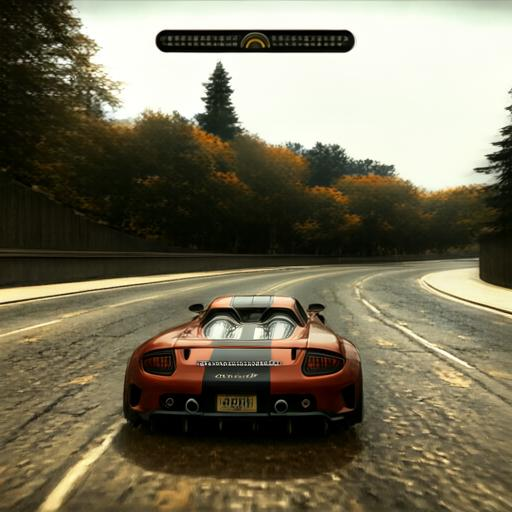
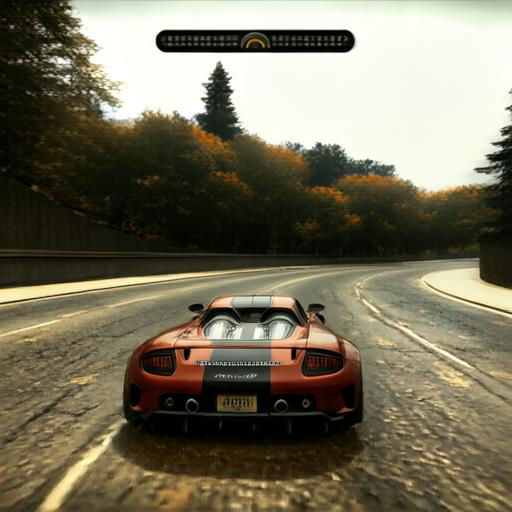

In [4]:
compare(
    steps_1, many_steps, cmap="gray", start_mode="horizontal", start_slider_pos=0.73
)

In [5]:
num_steps = 1
sigmas = np.linspace(1.0, 1 / num_steps, num_steps)

noise_scheduler.set_timesteps(sigmas=sigmas, device="cuda")
c_t = (
    train_transforms(orig_source_pil).unsqueeze(0).to(vae_val.dtype).to(vae_val.device)
)

with torch.no_grad():
    # Encode source image
    z_source = (
        # vae_val.encode(c_t, return_dict=False)[0]
        vae_val.encode(c_t, return_dict=False)[0].sample()
        * vae_val.config.scaling_factor
    )
    structured_noise = generate_structured_noise_batch_vectorized(
        z_source.float(),  # float обязателен для FFT
        noise_std=1.0,
        pad_factor=1.5,
        cutoff_radius=20,  # Фиксированный радиус для валидации
        input_noise=torch.randn_like(z_source.float()),
        sampling_method="fft",
    ).to(dtype=z_source.dtype, device=z_source.device)

    # sample = z_source
    sample = z_source + structured_noise * bridge_noise_sigma

    # ---------------------------------------------------------
    # ЦИКЛ СЭМПЛИНГА (Адаптировано из sample())
    # ---------------------------------------------------------
    # for i, t in enumerate(noise_scheduler.timesteps):
    for i in range(num_steps):
        t = noise_scheduler.timesteps[i]
        # 1. Масштабирование входа (если требуется шедулером)
        if hasattr(noise_scheduler, "scale_model_input"):
            denoiser_input = noise_scheduler.scale_model_input(sample, t)
        else:
            denoiser_input = sample
        denoiser_input = torch.cat([denoiser_input, z_source], dim=1)
        # 2. Предсказание направления (UNet)
        # unet_val(x, t) -> output
        # print(i, t, noise_scheduler.timesteps)
        pred = unet_val(
            denoiser_input,
            t.to(z_source.device).repeat(denoiser_input.shape[0]),
            return_dict=False,
        )[0]

        # 3. Шаг диффузии (Reverse Process)
        sample = noise_scheduler.step(pred, t, sample, return_dict=False)[0]

        # 4. Добавление стохастичности (Bridge Noise)
        # Не добавляем шум после последнего шага
        if i < len(noise_scheduler.timesteps) - 1:
            # Получаем таймстемп следующего шага
            next_timestep = (
                noise_scheduler.timesteps[i + 1]
                .to(z_source.device)
                .repeat(sample.shape[0])
            )

            # Получаем сигму для следующего шага
            sigmas_next = _get_sigmas_val(
                noise_scheduler,
                next_timestep,
                n_dim=4,
                dtype=weight_dtype,
                device=z_source.device,
            )

            # Формула Bridge Matching: шум пропорционален sqrt(sigma * (1-sigma))
            noise = torch.randn_like(sample)
            bridge_factor = (sigmas_next * (1.0 - sigmas_next)) ** 0.5

            sample = sample + bridge_noise_sigma * bridge_factor * noise
            sample = sample.to(z_source.dtype)

    # ---------------------------------------------------------

    # Декодирование результата
    output_image = (
        vae_val.decode(
            sample / vae_val.config.scaling_factor,
            return_dict=False,
        )[0]
    ).clamp(-1, 1)

total 20.403132677078247s, 0.20403132677078248s per img 4.901208142039104fps


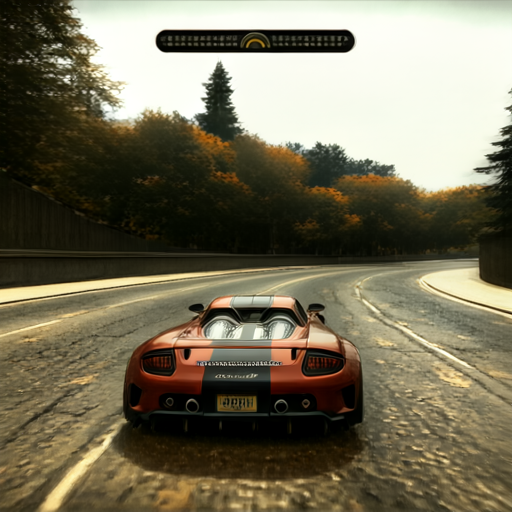

In [65]:
import time

amount = 100
start = time.time()
num_steps = 1
sigmas = np.linspace(1.0, 1 / num_steps, num_steps)
noise_scheduler.set_timesteps(sigmas=sigmas, device="cuda")
c_t = (
    train_transforms(orig_source_pil).unsqueeze(0).to(vae_val.dtype).to(vae_val.device)
)
# with torch.no_grad():
# Encode source image
z_source = (
    # vae_val.encode(c_t, return_dict=False)[0]
    vae_val.encode(c_t, return_dict=False)[0].sample()
    * vae_val.config.scaling_factor
)
for _ in range(amount):
    noise_scheduler.set_timesteps(sigmas=sigmas, device="cuda")
    # structured_noise = generate_structured_noise_batch_vectorized(
    #     z_source.float(),  # float обязателен для FFT
    #     noise_std=1.0,
    #     pad_factor=1.5,
    #     cutoff_radius=20,  # Фиксированный радиус для валидации
    #     input_noise=torch.randn_like(z_source),
    #     sampling_method="fft",
    # ).to(dtype=z_source.dtype, device=z_source.device)

    # sample = z_source
    sample = z_source + structured_noise * bridge_noise_sigma

    # ---------------------------------------------------------
    # ЦИКЛ СЭМПЛИНГА (Адаптировано из sample())
    # ---------------------------------------------------------
    # for i, t in enumerate(noise_scheduler.timesteps):
    for i in range(num_steps):
        t = noise_scheduler.timesteps[i]

        denoiser_input = sample
        denoiser_input = torch.cat([denoiser_input, z_source], dim=1)
        # 2. Предсказание направления (UNet)
        # unet_val(x, t) -> output
        # print(i, t, noise_scheduler.timesteps)
        pred = unet_val(
            denoiser_input,
            t.to(z_source.device).repeat(denoiser_input.shape[0]),
            return_dict=False,
        )[0]

        # 3. Шаг диффузии (Reverse Process)
        sample = noise_scheduler.step(pred, t, sample, return_dict=False)[0]

        # ---------------------------------------------------------

        # Декодирование результата
        output_image = (
            vae_val.decode(
                sample / vae_val.config.scaling_factor,
                return_dict=False,
            )[0]
        ).clamp(-1, 1)
total = time.time() - start
print(f"total {total}s, {total/amount}s per img {1/(total/amount)}fps")
pred_image_pil = transforms.ToPILImage()(output_image[0].cpu().float() * 0.5 + 0.5)
pred_image_pil